In [43]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v7
from Resources.Game import *


### Initializing shared game stats
##### Only once st the start

In [44]:
# stats = torch.Tensor([0, 0, 0, 0]) # batch index, white wins, black wins, draws
# torch.save(stats, '/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/stats')

##### Initialize Model

In [45]:
model = Model_v7()
# model_saves = os.listdir('../Monte Carlo/Model Saves MC v7 Parallel')
# if len(model_saves) > 0:
#     newest_model = max(int(i[6:-8]) for i in model_saves)
#     latest_batch_index = newest_model
#     model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v7 Parallel/model_{}_batches'.format(newest_model)))
# # model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v7 Parallel/model_800_batches'))
criterion = nn.MSELoss()

# error_hist =  []
latest_batch_index = 0


# error_hist = torch.load('./error_hist MC v7')
error_hist = []

In [90]:
all_pars = [i for i in model.parameters()]
for i in all_pars:
    print(i.shape)
print(all_pars[8][(0, )])

torch.Size([12, 1, 12, 3, 3])
torch.Size([12])
torch.Size([12, 1, 12, 5, 5])
torch.Size([12])
torch.Size([12, 1, 12, 8, 8])
torch.Size([12])
torch.Size([128, 636])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])
tensor([-0.0453,  0.0566,  0.0738,  0.0698, -0.0217, -0.0042, -0.0457,  0.0735,
         0.0692,  0.0758, -0.0144, -0.0457, -0.0866,  0.0559, -0.0230, -0.0224,
        -0.0004,  0.0579,  0.0513,  0.0609, -0.0637,  0.0875, -0.0519,  0.0710,
         0.0305, -0.0017, -0.0032,  0.0501,  0.0077,  0.0797, -0.0690,  0.0560,
         0.0486,  0.0123,  0.0805, -0.0163, -0.0772,  0.0695, -0.0707,  0.0046,
        -0.0370, -0.0542, -0.0708, -0.0417,  0.0509,  0.0498, -0.0744, -0.0303,
        -0.0025,  0.0777,  0.0280,  0.0101,  0.0196,  0.0488, -0.0050, -0.0466,
        -0.0426, -0.0501,  0.0775, -0.0873, -0.0628, -0.0294, -0.0490,  0.0040,
         0.0800, -0.0736,  0.0430, -0.0332,  0.0651,  0.0770,  0.0793,  0.0472,
         0.0680,  0.0491, -0.0199,  0.0097,  0.0098, -0.0023,

In [91]:
pars_early = []
pars_mid = []
pars_late = []

In [37]:
learning_rate = 5e-5
weight_decay = 1e-3     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    # learning_rate = 5e-4 * 500 / (500 + game_count) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

In [ ]:
# Baseline: 
# L2 weight decay = 1e-2
# lr = 5e-5

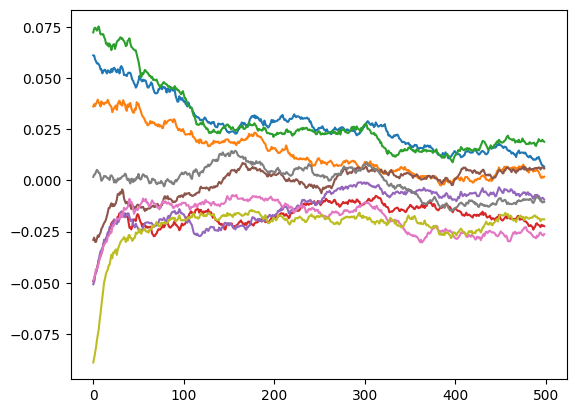

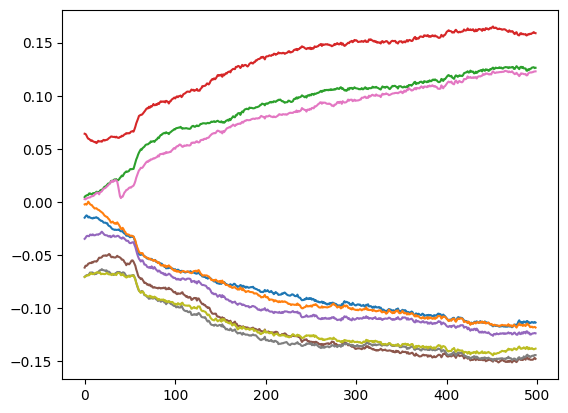

In [38]:
for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [42]:
learning_rate = 5e-5
weight_decay = 1e-3     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    # learning_rate = 5e-4 * 500 / (500 + game_count) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

In [ ]:
# L2 weight decay = 1e-3
# lr = 5e-5


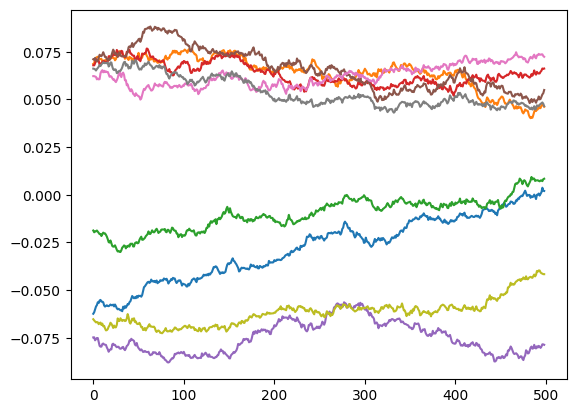

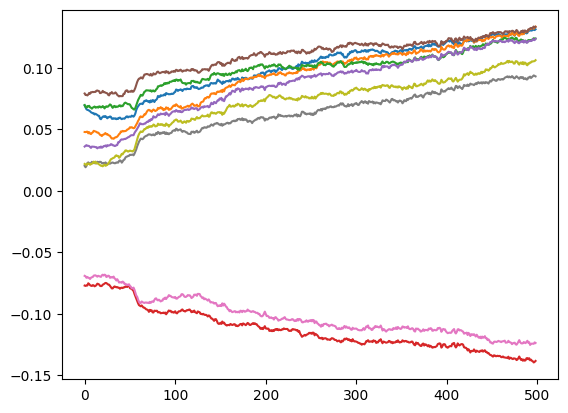

In [43]:
for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [47]:
# learning_rate = 5e-5
weight_decay = 1e-3     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    learning_rate = 5e-4 * 100 / (100 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

In [48]:
# L2 weight decay = 1e-3
# lr = 5e-4 * 100 / (100 + batch)

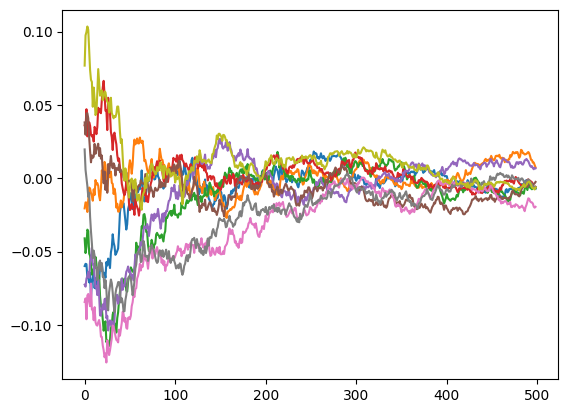

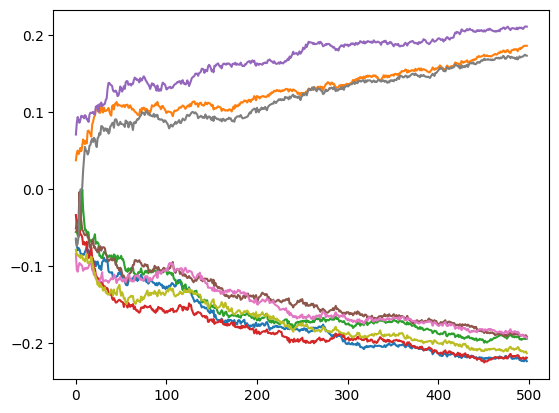

In [49]:
for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [53]:
# learning_rate = 5e-5
weight_decay = 1e-4     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    learning_rate = 2e-3 * 100 / (100 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

In [54]:
# L2 weight decay = 1e-4
# lr = 2e-3 * 100 / (100 + batch)

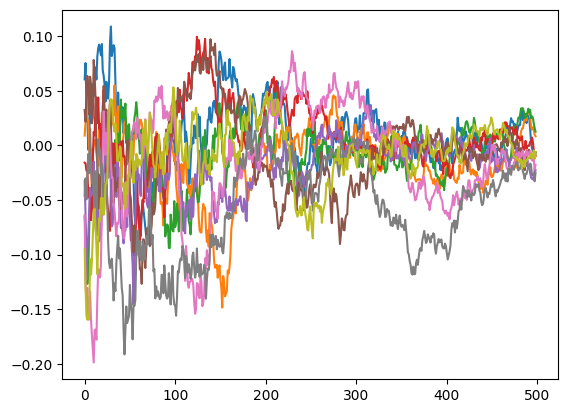

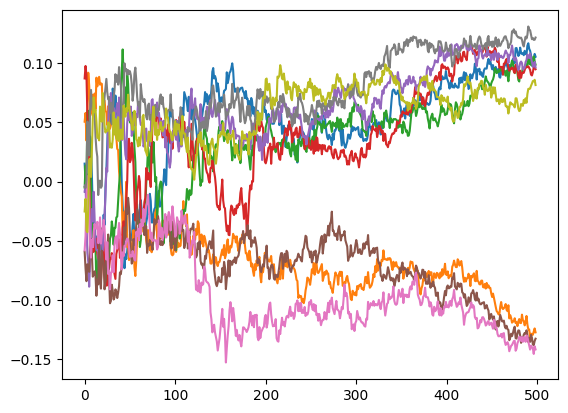

In [55]:
for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [59]:
# learning_rate = 5e-5
weight_decay = 1e-4     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 1500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    learning_rate = 2e-3 * 500 / (500 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

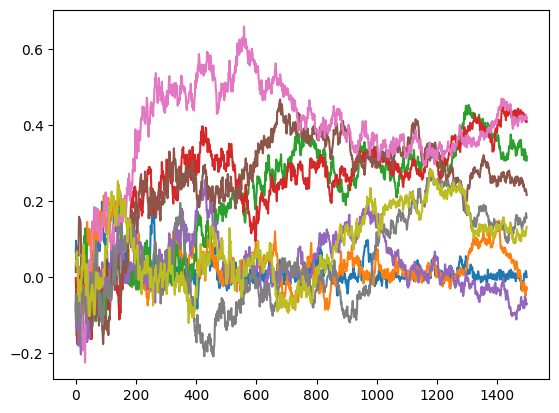

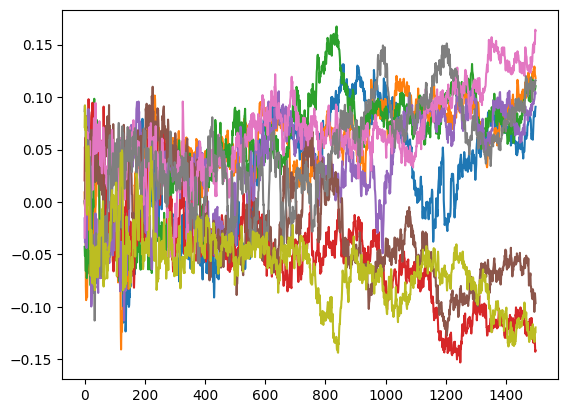

In [60]:
# L2 weight decay = 1e-4
# lr = 2e-3 * 500 / (500 + batch)

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [92]:
# learning_rate = 5e-5
weight_decay = 1e-4     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 1500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_mid.append(all_pars[4][(0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    learning_rate = 2e-3 * 250 / (250 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

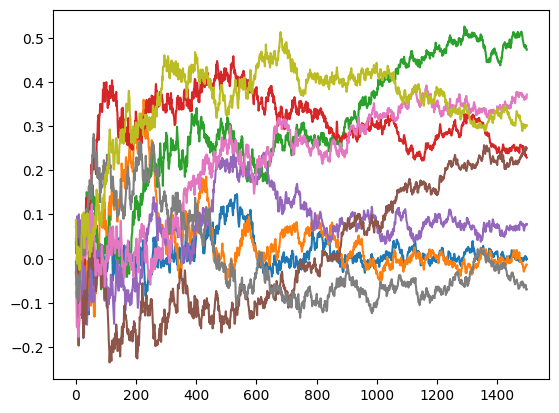

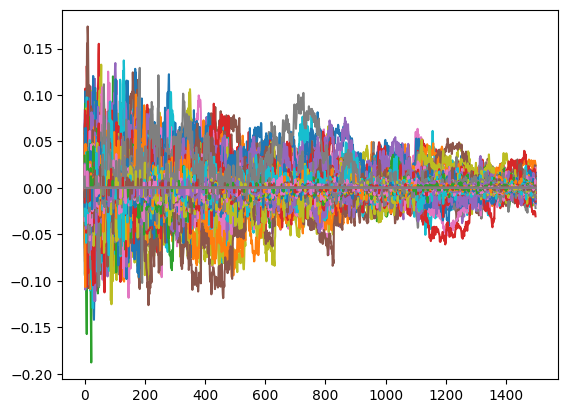

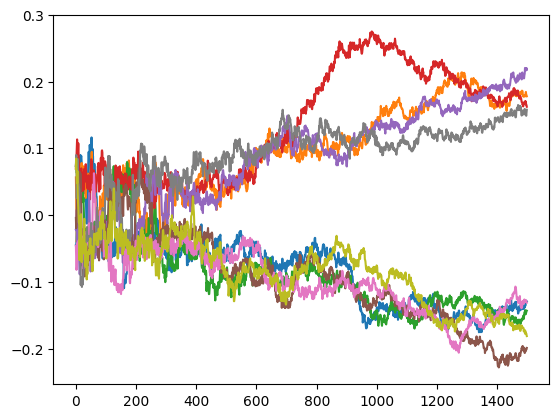

In [97]:
# L2 weight decay = 1e-4
# lr = 2e-3 * 250 / (250 + batch)

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(768):
    plt.plot([i[k].detach().numpy() for i in pars_mid])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [71]:
# learning_rate = 5e-5
weight_decay = 1e-3     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_early.append(all_pars[0][(0, 0, 0)].clone().flatten())
    pars_mid.append(all_pars[4][(0)].clone().flatten())
    pars_late.append(all_pars[8][(0)].clone().flatten())
    # print(all_pars[0][(0, 0, 0)])

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    # learning_rate = 2e-3 * 500 / (500 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

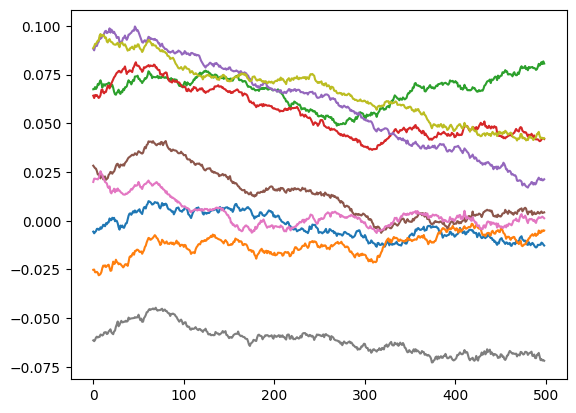

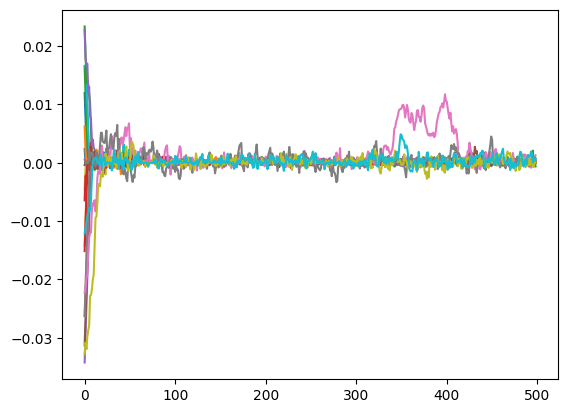

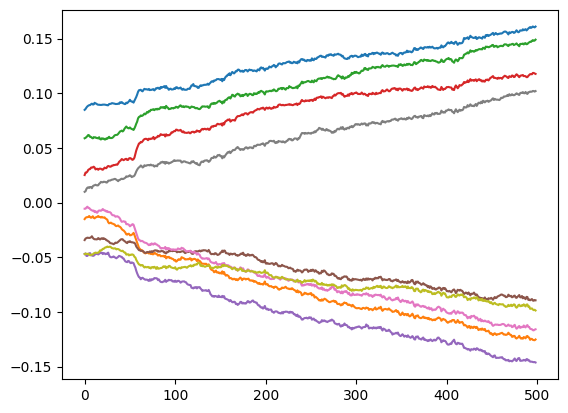

In [73]:
# L2 weight decay = 1e-3
# lr = 5e-5
for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_early])
plt.show()

for k in range(20):
    plt.plot([i[k].detach().numpy() for i in pars_mid])
plt.show()

for k in range(9):
    plt.plot([i[k].detach().numpy() for i in pars_late])
plt.show()

In [74]:
print(len([i[k].detach().numpy() for i in pars_mid]))

499


tensor([ 0.0320,  0.1768, -0.0216,  0.3142,  0.1633,  0.0817,  0.0160, -0.1423],
       grad_fn=<AddBackward0>)


In [94]:
[print(len(i)) for i in pars_mid]

768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768
768


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [46]:
# learning_rate = 5e-5
weight_decay = 1e-9     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

sum_mid_layer = []
all_pars_save = []

for batch in range(1, 500):

    all_pars = [i for i in model.parameters()]
    pars_save = [i.clone().flatten() for i in all_pars]
    all_pars_save.append([i.clone().flatten() for i in all_pars])

    sum_mid_layer.append( (sum(abs(j) for j in pars_save[6])).detach().numpy() )

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    print('training batch ', batch)
    t0 = time.time()

    # training step
    model.train()
    learning_rate = 2e-3 * 100 / (100 + batch) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    # if batch % 10 == 0 and batch > 0:

    #     print('batches: ', batch)
    
    # if batch % 50 == 0 and batch > 0:

    #     plt.figure(figsize=(6, 3))
    #     plt.plot(error_hist, label='(training) error hist')
    #     plt.show()

    #     plt.figure(figsize=(6, 3))
    #     plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
    #     plt.show()


training batch  1
training batch  2
training batch  3
training batch  4
training batch  5
training batch  6
training batch  7
training batch  8
training batch  9
training batch  10
training batch  11
training batch  12
training batch  13
training batch  14
training batch  15
training batch  16
training batch  17
training batch  18
training batch  19
training batch  20
training batch  21
training batch  22
training batch  23
training batch  24
training batch  25
training batch  26
training batch  27
training batch  28
training batch  29
training batch  30
training batch  31
training batch  32
training batch  33
training batch  34
training batch  35
training batch  36
training batch  37
training batch  38
training batch  39
training batch  40
training batch  41
training batch  42
training batch  43
training batch  44
training batch  45
training batch  46
training batch  47
training batch  48
training batch  49
training batch  50
training batch  51
training batch  52
training batch  53
tr

In [102]:
flat_pars = [i.clone().flatten() for i in all_pars]

In [103]:
[i.shape for i in flat_pars]

[torch.Size([1296]),
 torch.Size([12]),
 torch.Size([3600]),
 torch.Size([12]),
 torch.Size([9216]),
 torch.Size([12]),
 torch.Size([81408]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([1])]

In [ ]:
max([i[6][400].detach().numpy() for i in all_pars_save])

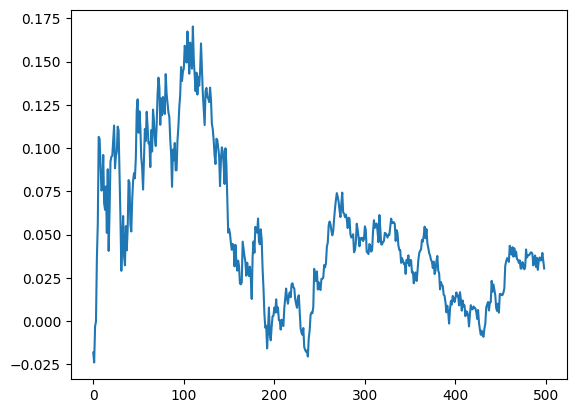

In [47]:
plt.plot([i[6][400].detach().numpy() for i in all_pars_save])
plt.show()

In [111]:
print(pars_save[0][0][0])

tensor(0.0931, grad_fn=<SelectBackward0>)


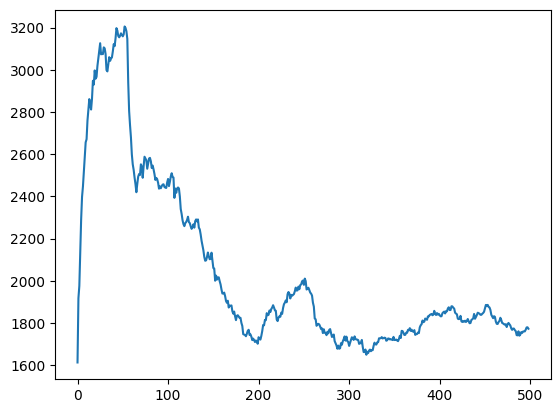

In [48]:
plt.plot(sum_mid_layer)
plt.show()